In [1]:
import numpy as np 
import matplotlib.pyplot as plt
#minor style things
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [548 / 72, 390 / 72]
plt.rcParams["font.size"] = 12
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.dpi"] = 300

In [2]:
from RW_helpers import *

In [3]:
N_order = 3               # 3 for 3P, 2 for 2P
lambd = 1.3/1000          # Wavelength [mm]
n = 1.3225                # Refractive index
k = (2*n*np.pi)/lambd       # Wavenumber
num_apt = 1.05            # Numerical aperture
length = 200                #mm
mag = 25.                    # Magnification rate from input to objective
f = length/mag  # Focal length of objective (Nikon) [mm]
grid_size = 20           # BFP resolution
L_bfp = 16.80             # BFP diameter [mm]               
fwhm_pupil = 8.24 #[mm]

In [4]:
r_pupil = f * num_apt
r_bfp = L_bfp / 2
na_eff = num_apt
#effective NA can be limited by the size of the back focal plane
if r_bfp < r_pupil:
    na_eff = r_bfp / f
alpha = np.arcsin(na_eff / n)

In [5]:
x = np.arange(-2, 2, 0.05)/1000
y = [0]
z = np.arange(-3, 3, 0.05)/1000

In [7]:
xy_profile = np.zeros_like(x)
for i in range(len(x)):
    x_p = x[i]
    #get the integrated electric field
    E_x, E_y, E_z = E_integrate(x_p,0,0,alpha,k,f,n,fwhm_pupil, grid_size, grid_size, None)
    I1 = np.abs(E_x)**2 + np.abs(E_y)**2 + np.abs(E_z)**2
    I_np = I1**N_order
    xy_profile[i] = I_np

In [8]:
normed_xy = xy_profile / np.max(xy_profile)
a = normed_xy >= 0.5
np.sum(a) * (x[1] - x[0]) * 1000

np.float64(0.5500000000000015)

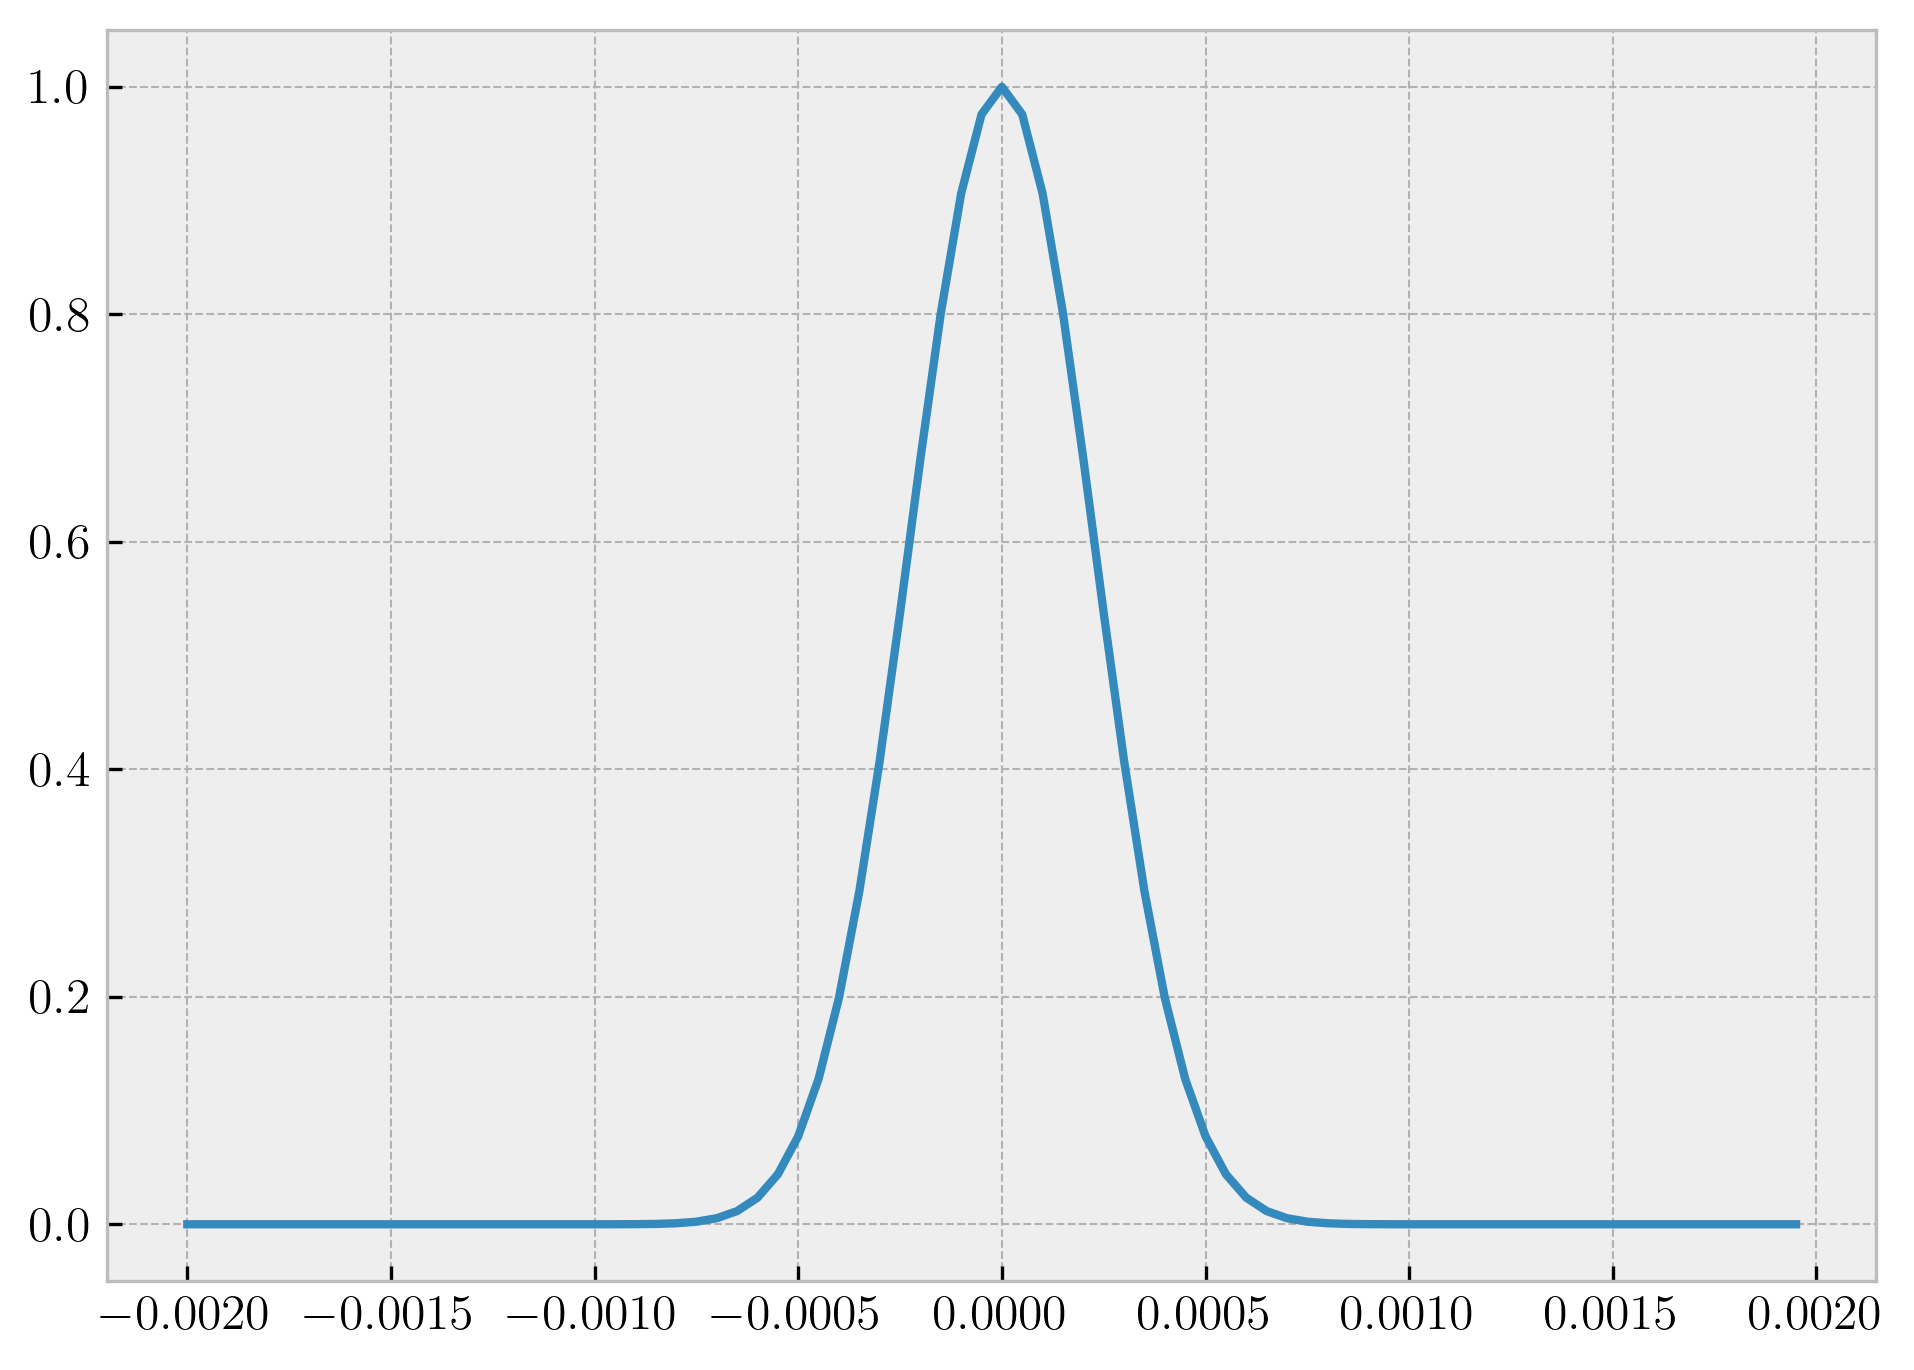

In [9]:
plt.plot(x, normed_xy)

In [10]:
z_profile = np.zeros_like(z)
for i in range(len(z)):
    z_p = z[i]
    #get the integrated electric field
    E_x, E_y, E_z = E_integrate(0,0,z_p,alpha,k,f,n,fwhm_pupil, grid_size, grid_size, None)
    I1 = np.abs(E_x)**2 + np.abs(E_y)**2 + np.abs(E_z)**2
    I_np = I1**N_order
    z_profile[i] = I_np

In [11]:
normed_z = z_profile / np.max(z_profile)
a = normed_z >= 0.5
np.sum(a) * (z[2] - z[1]) * 1000

np.float64(1.6500000000000044)

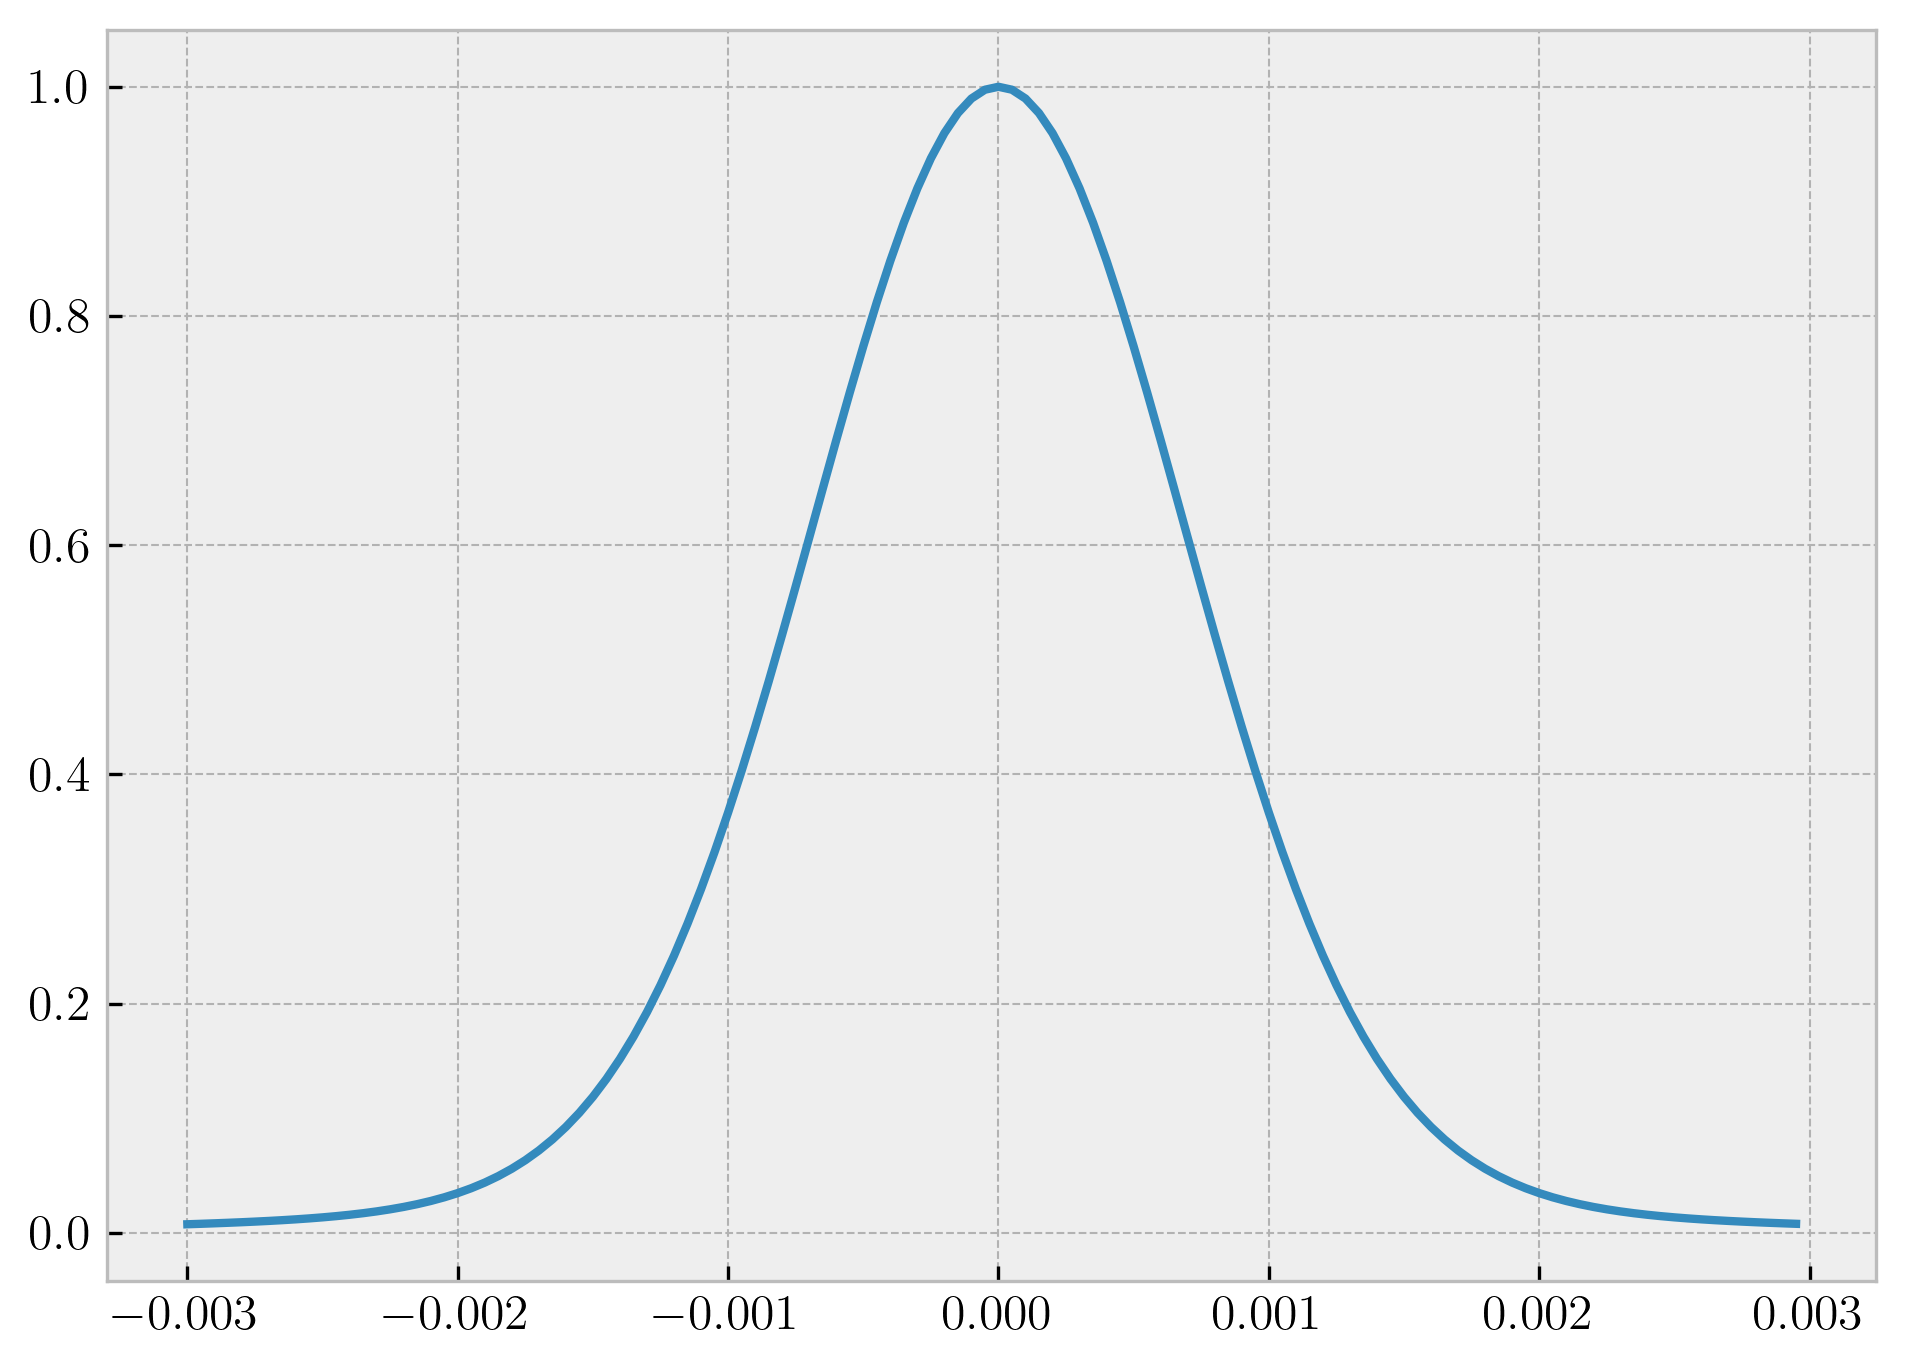

In [12]:
plt.plot(z, normed_z)

In [42]:
L_ffp = 0.005             # FFP size [mm]
grid_ffp = 400
theta_grid_size = 10

In [43]:
import time
t_1 = time.time()
x, y, intensity_map =  intensity_grid(L_ffp, grid_ffp, alpha, k, f, n, fwhm_pupil, theta_grid_size, N_order, None)
t_2 = time.time()
print(f"Time elapsed: {np.round(t_2 - t_1, 3)}s")

Time elapsed: 21.522s


In [44]:
def plot_intensity(x, y, intensity_map):
    fig, ax = plt.subplots(dpi = 300)
    plt.imshow(intensity_map / np.max(intensity_map),
            extent=[x[0], x[-1], y[0], y[-1]],
        origin='lower',
        aspect = "equal",
        cmap='Greys_r')
    ax.grid(False)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    plt.colorbar(label='Intensity (Normalized)')
    plt.savefig("figures/intensity_map.png")
    plt.show()


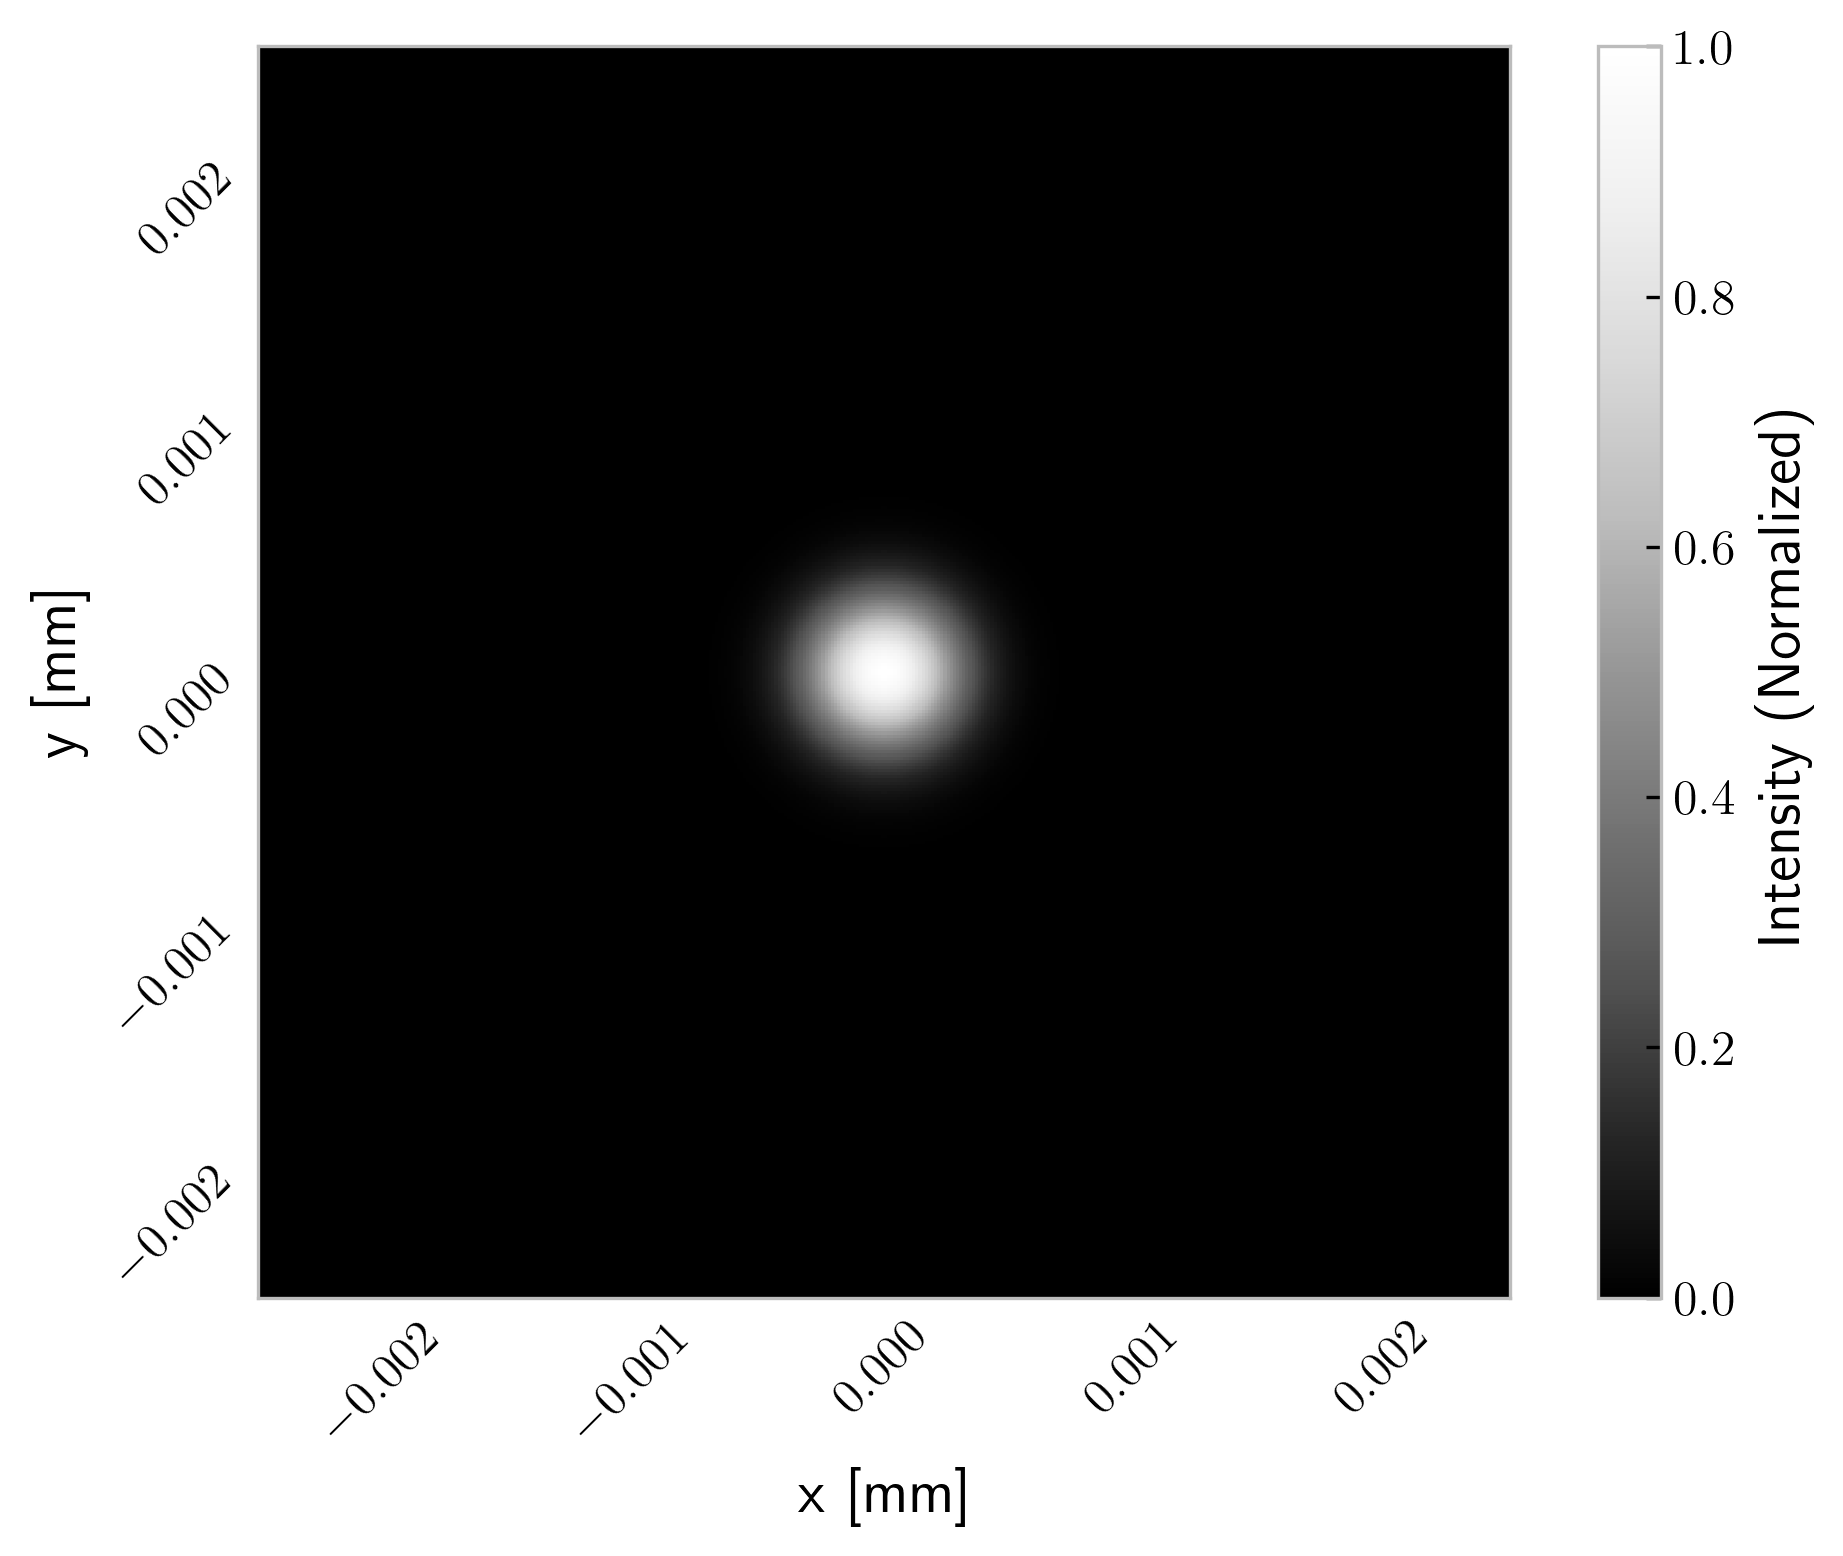

In [45]:
plot_intensity(x, y, intensity_map)

In [46]:
import subprocess

def parallel_intensity_grid(
    L_ffp,
    grid_ffp,
    alpha,
    k,
    f,
    n,
    fwhm_pupil,
    theta_grid_size,
    N_order,
    aberration_map=None,
    output="psf_output.npz",
    python_executable="python",
    script_path="RW_run_parallel.py"
):
    """
    Calls run_psf.py with the provided arguments using subprocess.
    This avoids all multiprocessing issues inside Jupyter.
    """

    cmd = [
        python_executable, script_path,
        "--L-ffp", str(L_ffp),
        "--grid-ffp", str(grid_ffp),
        "--alpha", str(alpha),
        "--k", str(k),
        "--f", str(f),
        "--n", str(n),
        "--fwhm-pupil", str(fwhm_pupil),
        "--theta-grid-size", str(theta_grid_size),
        "--N-order", str(N_order),
        "--output", output
    ]

    if aberration_map is not None:
        cmd += ["--aberration-map", str(aberration_map)]

    # Run the script
    subprocess.run(cmd, check=True)

    print(f"PSF computed and saved to: {output}")
    output_files = np.load(output)
    return output_files["x"], output_files["y"], output_files["I"]

In [47]:
import time
t_1 = time.time()
x, y, I = parallel_intensity_grid(L_ffp, grid_ffp, alpha, k, f, n, fwhm_pupil, theta_grid_size, N_order, None, "parallel_output/psf_output.npz")
t_2 = time.time()
print(f"Time elapsed: {np.round(t_2 - t_1, 3)}s")

PSF computed and saved to: parallel_output/psf_output.npz
Time elapsed: 7.583s


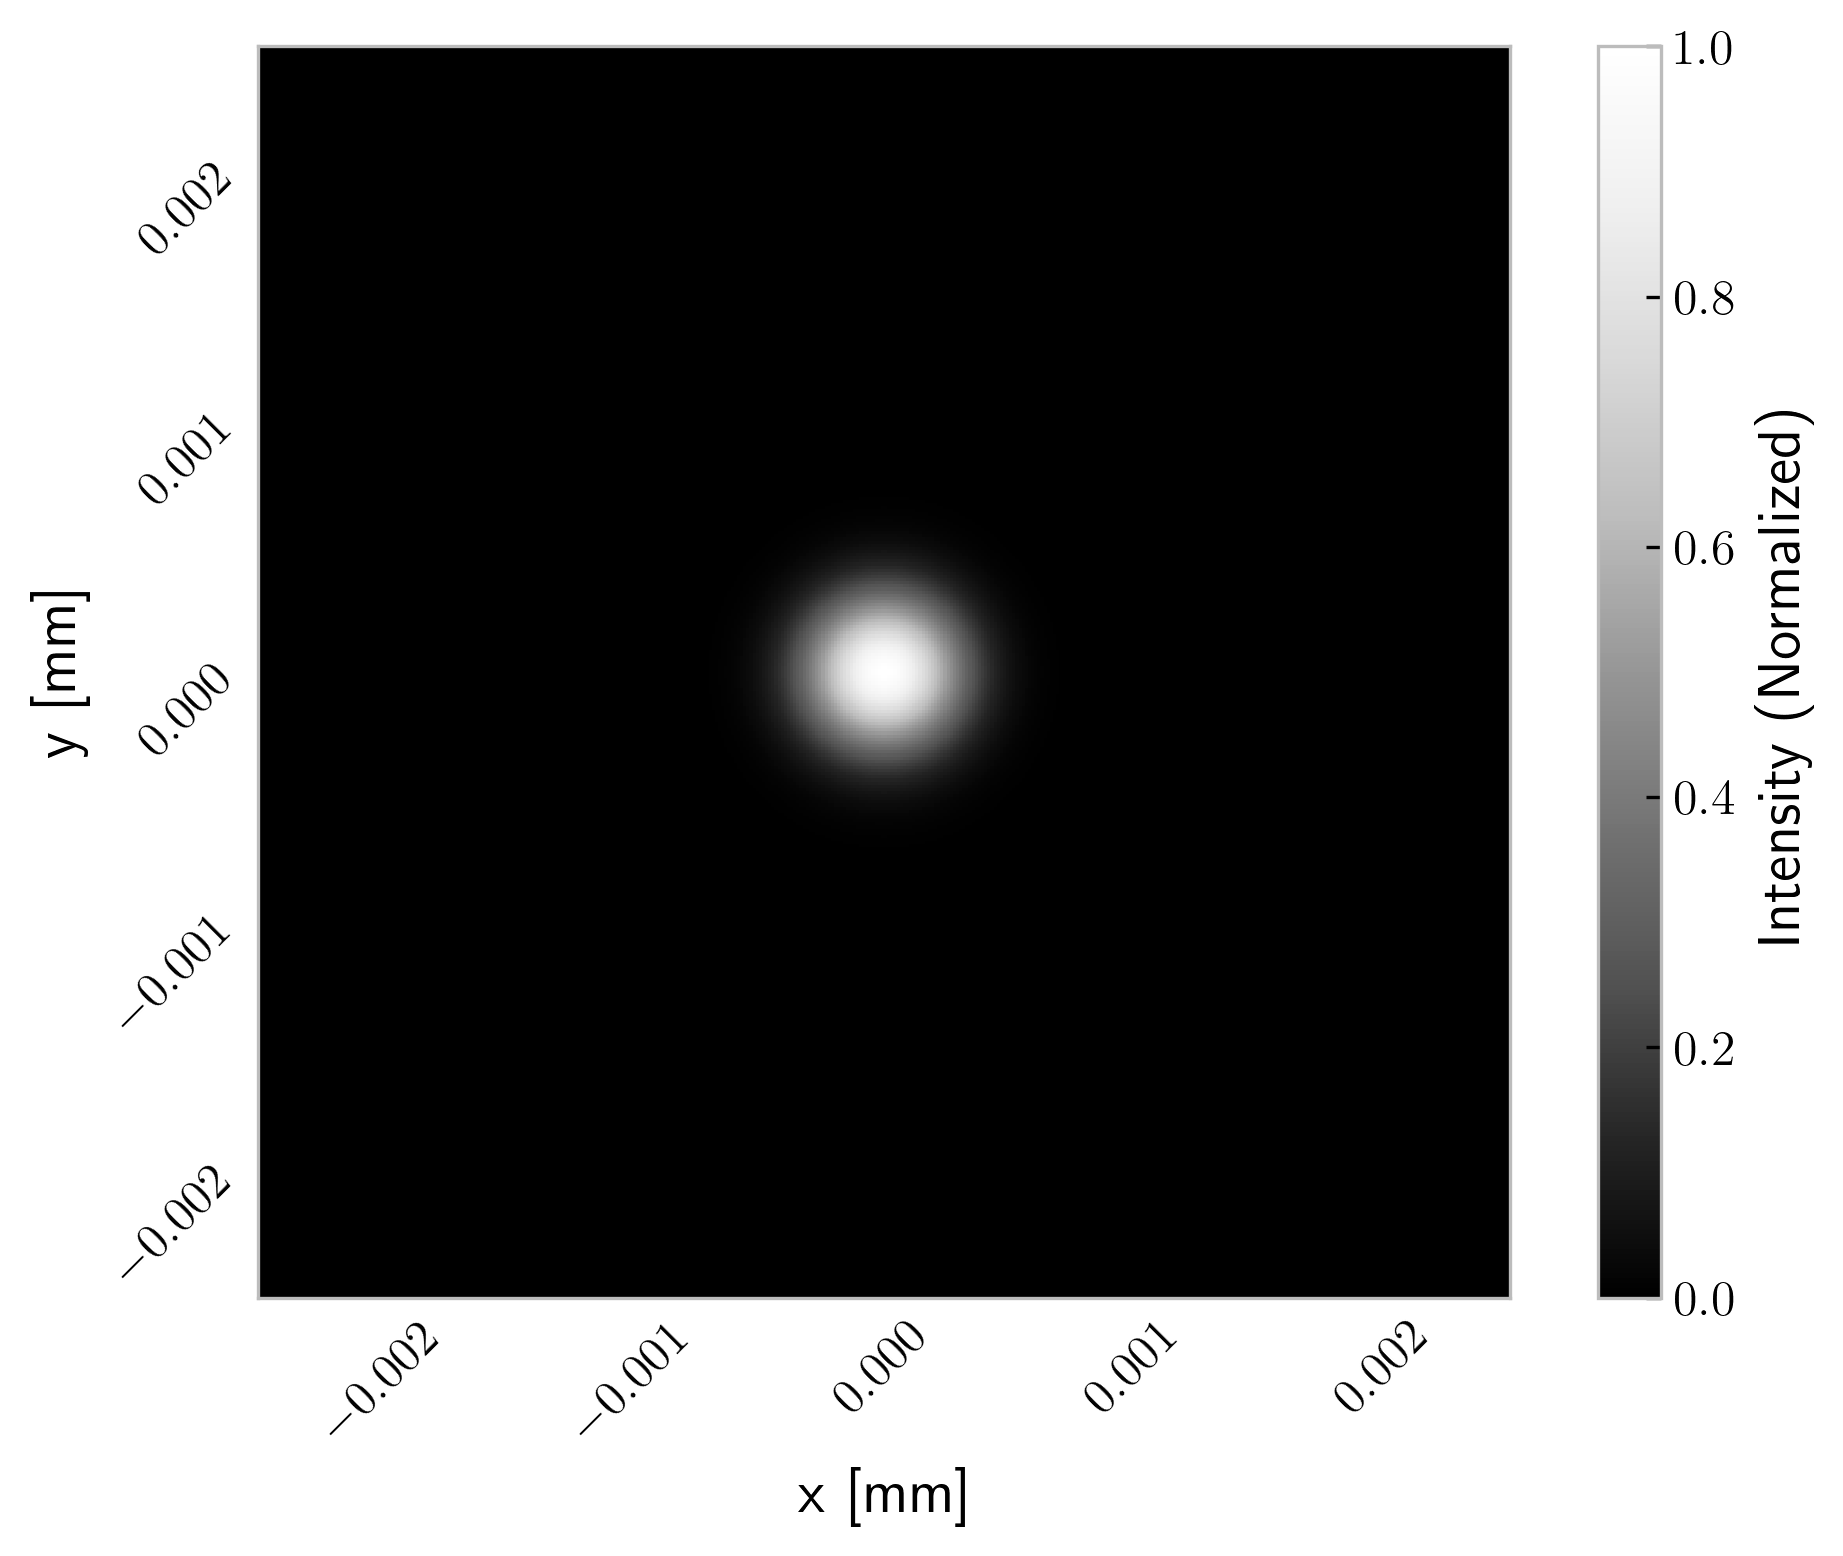

In [48]:
plot_intensity(x, y, I)

In [49]:
L_ffp = 0.005             # FFP size [mm]
theta_grid_size = 10

grid_sizes = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 250, 500, 750, 1000])
reg_times = np.zeros_like(grid_sizes)
parallel_times = np.zeros_like(grid_sizes)

for i, grid_size in enumerate(grid_sizes):
    t_1 = time.time()
    x, y, intensity_map =  intensity_grid(L_ffp, grid_size, alpha, k, f, n, fwhm_pupil, theta_grid_size, N_order, None)
    t_2 = time.time()
    reg_times[i] = t_2 - t_1

    t_1 = time.time()
    x, y, I = parallel_intensity_grid(L_ffp, grid_size, alpha, k, f, n, fwhm_pupil, theta_grid_size, N_order, None, "parallel_output/psf_output.npz")
    t_2 = time.time()
    parallel_times[i] = t_2 - t_1 

    print("Done with size", grid_size)
    

PSF computed and saved to: parallel_output/psf_output.npz
Done with size 10
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 20
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 30
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 40
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 50
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 60
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 70
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 80
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 90
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 100
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 250
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 500
PSF computed and saved to: parallel_output/psf_output.npz
Done with size 750
PSF comp

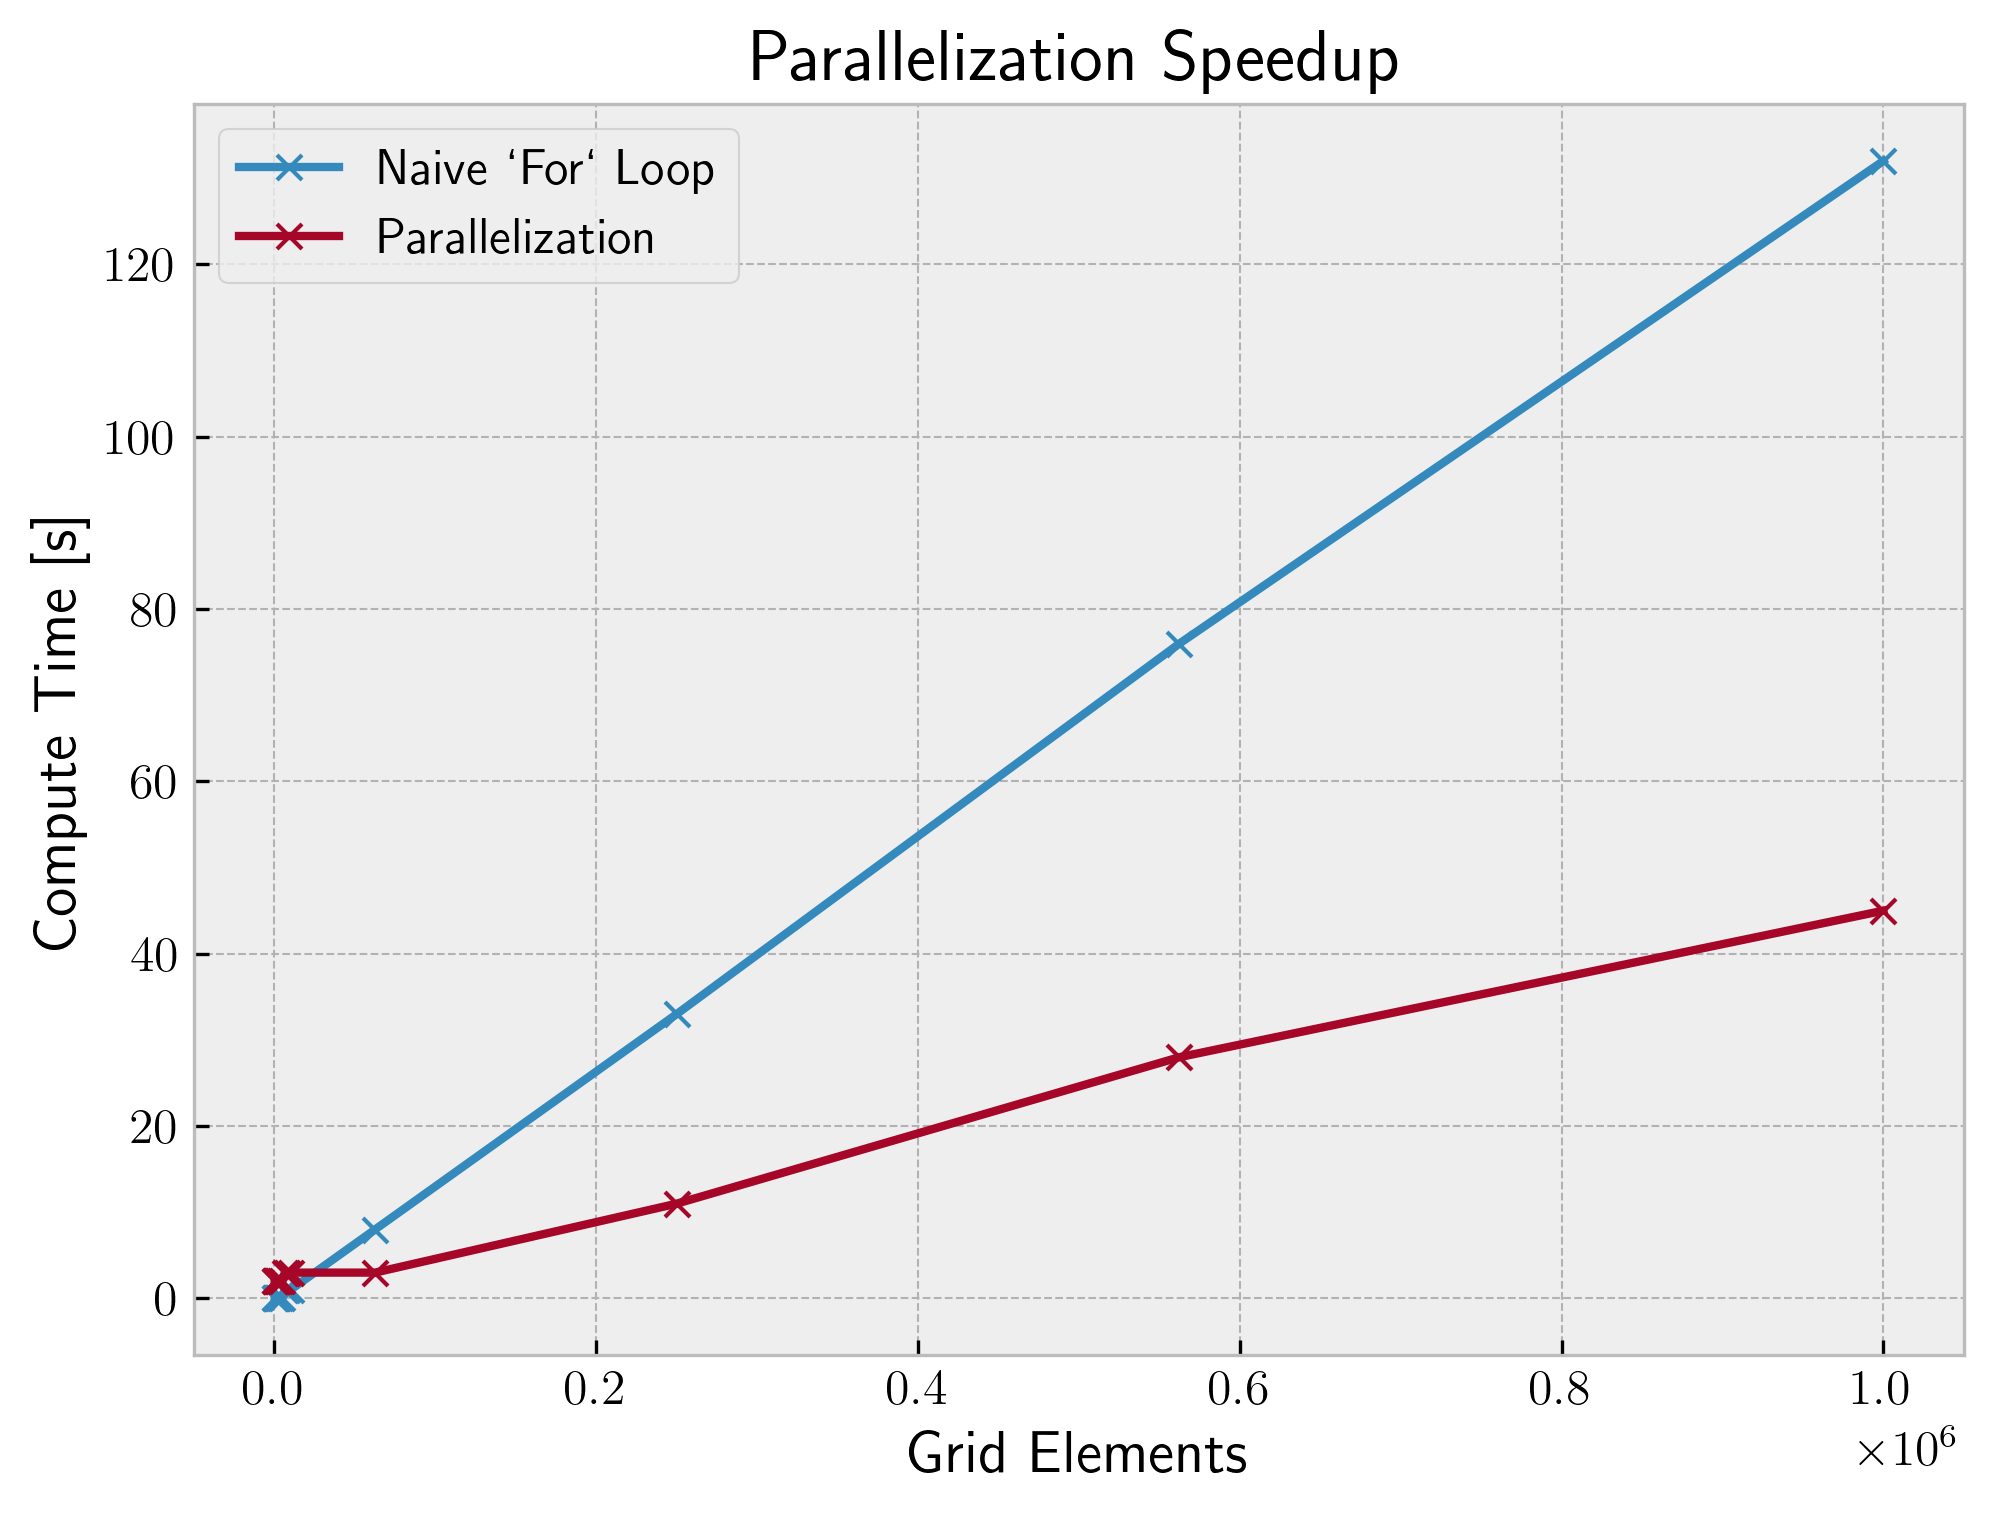

In [ ]:
fig, ax = plt.subplots(dpi = 300)
ax.plot(grid_sizes ** 2, reg_times, marker = "x", label = "Naive `For` Loop")
ax.plot(grid_sizes ** 2, parallel_times, marker = "x", label = "Parallelization")
ax.set_xlabel("Grid Elements")
ax.set_ylabel("Compute Time [s]")
ax.set_title("Parallelization Speedup")
ax.legend()
plt.savefig("figures/parallelization.pn")